# XHEC: Session 5-2  

Explore topic extraction and sentiment analysis existing libraries 

## Import libraries 

In [ ]:
# # Load file from drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import os
os.getcwd()
#os.chdir("path to your drive folder") # path to your drive folder

'/content'

In [ ]:
!pwd
!ls

/content
sample_data


In [ ]:
cat requirements_c5.txt

cat: requirements_c5.txt: No such file or directory


In [ ]:
!python3 -m pip install -r requirements_c5.txt

In [ ]:
#
!python3 -m pip install pyLDAvis==3.3.1 --no-cache-dir
!python3 -m spacy download fr_core_news_sm 


In [ ]:
import sys
sys.path.insert(0, 'path_to_the_file_process.py')
import process

In [ ]:

import os
import numpy as np
import pandas as pd
import pickle
import operator
from tqdm import tqdm_notebook as tqdm
import nltk
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpor
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models
import seaborn as sns
import matplotlib.pyplot as plt
import shap

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
import spacy
#!python3 -m spacy download fr_core_news_sm # to run juste one time
#!pip install vaderSentiment

import sys
sys.path.insert(0, './')
import process

%load_ext autoreload
%autoreload 2


Can't initialize NVML


In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

## Load data 

In [ ]:
DATASET_SIZE = 30000
def get_reviews(filepath, nrows=None):
    df = pd.read_parquet(filepath)
    if nrows !=None:
      df = df.sample(nrows)
    return df

In [ ]:
#TO DO: Load the pickle in 'document' (type: pd.DataFrame)
path = "path to your data"
reviews = get_reviews(path, DATASET_SIZE)


In [ ]:
#TO DO: Check document variable
reviews.head()

,Unnamed: 0,page,titre,verbatim,date,note,reponse,date_experience,fournisseur,source,clean_verb,tokens,tokens_lem,tokens_processed,tokens_lem_processed
21127,21127,23,Avis client,Pour l’instant aucun problème,le 09/10/2022 par STEPHAN V.,4,None,suite à une expérience du 30/09/2022,https://www.avis-verifies.com/avis-clients/hap...,avis_verifies,pour l’instant aucun problème,"[[pour, ], [l’, ], [instant, ], [aucun, ], [pr...","[[pour, ], [l’, ], [instant, ], [aucun, ], [pr...","[instant, problème]",[instant]
4727,4727,27,Bonjour de la part d’un ancien démarcheur Eni,Bonjour je parle en ayants était démarcheur po...,13 juin 2020,1,None,Date de l'expérience: 13 juin 2020,https://fr.trustpilot.com/review/eni.fr,trustpilot,bonjour je parle en ayants était démarcheur po...,"[[bonjour, ], [je, ], [parle, ], [en, ], [ayan...","[[bonjour, ], [je, ], [parl, ], [en, ], [ayant...","[bonjour, ayants, démarcheur, eni, semaineon, ...","[bonjour, parl, démarcheur, eni, pend, semaine..."
3402,3402,113,OHM énergie n'a pas attendu le délai de…,OHM énergie n'a pas attendu le délai de rétrac...,10 mars 2021,1,"Bonjour,\nL'annulation aurait pu se faire plus...",Date de l'expérience: 10 mars 2021,https://fr.trustpilot.com/review/ohm-energie.com,trustpilot,ohm énergie n'a pas attendu le délai de rétrac...,"[[ohm, ], [énergie, ], [n', ], [a, ], [pas, ],...","[[ohm, ], [énerg, ], [n', ], [a, ], [pas, ], [...","[ohm, énergie, délai, rétractation, prélever, ...","[ohm, énerg, del, rétract, prélev, somm, argen..."
37193,37193,498,Avis client,Très bien,le 02/03/2022 par FREDERIC C.,5,None,suite à une expérience du 07/02/2022,https://www.avis-verifies.com/avis-clients/edf...,avis_verifies,très bien,"[[très, ], [bien, ]]","[[tres, ], [bien, ]]",[],[]
19718,19718,312,Avis client,Total énergies = total arnaque,le 06/10/2022 par ANNE LYS M.,1,"Commentaire de TotalEnergies\nBonjour Madame,\...",suite à une expérience du 27/09/2022,https://www.avis-verifies.com/avis-clients/tot...,avis_verifies,total énergies = total arnaque,"[[total, ], [énergies, ], [=, ], [total, ], [a...","[[total, ], [énerg, ], [=, ], [total, ], [arna...","[total, énergies, total, arnaque]","[total, énerg, total, arnaqu]"


In [ ]:
### Exemple of preprocessing already done
print(reviews["verbatim"][1])
print('----------')
print(reviews["tokens_lem_processed"][1])

Engie facture a ses clients des sommes exorbitants !

Engie mon facturer un technicien pour le gaz , alors que GRDF m’a bien préciser que le gaz était déjà en service dans mon logement ! Résultat des courses une facture de 71 euros juste pour ouvrir le compteur électrique de mon nouveau logement , concernant le gaz personne est intervenu sur ma chaudière j’ai dû le faire tout seul !

Engie savent prendre l’argent à tord mais quand ont leur explique malheureusement plus personne est là !
----------
['engi' 'factur' 'client' 'somm' 'exorbit' 'engi' 'factur' 'technicien'
 'gaz' 'alor' 'grdf' 'précis' 'gaz' 'déjà' 'servic' 'dan' 'log' 'résultat'
 'cours' 'factur' 'euros' 'ouvr' 'compteur' 'électr' 'log' 'concern' 'gaz'
 'person' 'intervenu' 'chaudi' 'dû' 'fair' 'engi' 'savent' 'prendr'
 'argent' 'tord' 'expliqu' 'malheur' 'person']


## Topic extraction : LDA  with Gensim


### Preprocessing of reviews to be used by LDA



In [ ]:
'''
TO DO : Create a dictionary from 'tokens_lem_processed' containing the number of times a word appears 
in the training set using gensim.corpora.Dictionary and call it 'dictionary'
'''
tokens = ...
dictionary = ...

In [ ]:
'''
TO DO : Remove very rare and very common words:
- words appearing less than 15 times
- words appearing in more than 10% of all documents
'''
dictionary.filter_extremes(no_below=..., no_above=..., keep_n= 100000)

In [ ]:
'''
TO DO : Create the Bag-of-words model for each document i.e for each document we create a dictionary reporting how many
words and how many times those words appear. Save this to 'corpus' (HINT: check dictionary.doc2bow(tokens[0]))
'''
corpus = [dictionary.doc2bow(...) for tok in ...]

In [ ]:
'''
Preview BOW for our sample preprocessed document
'''
review_num = 20
bow_doc_x = corpus[review_num]

for i in range(len(bow_doc_x)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_x[i][0], 
                                                     dictionary[bow_doc_x[i][0]], 
                                                     bow_doc_x[i][1]))

Word 18 ("semain") appears 1 time.
Word 24 ("dan") appears 1 time.
Word 51 ("contrat") appears 1 time.
Word 56 ("direct") appears 1 time.
Word 318 ("conserv") appears 1 time.
Word 319 ("déménag") appears 1 time.
Word 320 ("energ") appears 1 time.


### Train LDA Model

In [ ]:
#TO DO: build lda model
'''
Train your lda model using gensim.models.ldamodel.LdaModel and save it to 'ldaModel'
'''
nb_topics = 10
alpha = 0.1
eta = 0.1
random_state = 42
np.random.seed(random_state)

ldaModel = gensim.models.ldamodel.LdaModel(corpus=...,
                                           id2word=...,
                                           num_topics=..., 
                                           alpha=alpha,
                                           eta=eta)

In [ ]:
ldaModel.show_topics()

[(0,
  '0.030*"pass" + 0.023*"téléphon" + 0.021*"san" + 0.020*"dan" + 0.013*"demand" + 0.013*"pann" + 0.009*"temp" + 0.009*"chang" + 0.009*"mêm" + 0.008*"signal"'),
 (1,
  '0.041*"factur" + 0.025*"pai" + 0.025*"mois" + 0.021*"prélev" + 0.014*"demand" + 0.011*"fair" + 0.011*"résili" + 0.011*"euros" + 0.011*"san" + 0.010*"dan"'),
 (2,
  '0.040*"contrat" + 0.034*"technicien" + 0.021*"intervent" + 0.018*"appel" + 0.017*"chaudi" + 0.016*"engi" + 0.014*"commercial" + 0.012*"jour" + 0.011*"rdv" + 0.011*"san"'),
 (3,
  '0.031*"tre" + 0.021*"électr" + 0.020*"factur" + 0.019*"mois" + 0.016*"aur" + 0.015*"jam" + 0.014*"ver" + 0.013*"abon" + 0.012*"niveau" + 0.012*"moin"'),
 (4,
  '0.019*"total" + 0.019*"appel" + 0.016*"jour" + 0.016*"factur" + 0.013*"compteur" + 0.013*"contrat" + 0.012*"mêm" + 0.012*"demand" + 0.012*"direct" + 0.011*"toujour"'),
 (5,
  '0.023*"qualit" + 0.020*"prix" + 0.016*"excellent" + 0.016*"présent" + 0.016*"conseil" + 0.015*"moment" + 0.014*"rapport" + 0.014*"parfait" + 0.01

In [ ]:
cm = CoherenceModel(model=ldaModel, corpus=corpus, dictionary=dictionary, coherence='u_mass')
coherence = cm.get_coherence()  # get coherence value

In [ ]:
coherence

-2.44398240540906

In [ ]:
#pyLDAvis visualisation
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(ldaModel, corpus, dictionary)
vis

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.168827  0.059769       1        1  21.123779
4      0.134404  0.049452       2        1  19.262649
2      0.067567  0.132231       3        1  10.816691
7      0.007794 -0.140272       4        1   9.528643
9      0.113048 -0.208692       5        1   8.256779
8     -0.269011 -0.069621       6        1   7.380667
6     -0.266964  0.148852       7        1   7.162271
0      0.024982  0.107868       8        1   6.312863
3      0.126211  0.037861       9        1   5.167184
5     -0.106858 -0.117446      10        1   4.988473, topic_info=              Term         Freq        Total Category  logprob  loglift
100          rapid  2640.000000  2640.000000  Default  30.0000  30.0000
113          écout  1795.000000  1795.000000  Default  29.0000  29.0000
351        conseil  2810.000000  2810.000000  Default  28.0000  28.0000
286  professionnel  1515.000000  1515.000000  Default  27.0000  27.0000
313        efficac  1393.000000  1393.000000  Default  26.0000  26.0000
..             ...          ...          ...      ...      ...      ...
97            merc   160.782316  1455.337277  Topic10  -4.7557   0.7951
244    fournisseur   187.846753  3183.108553  Topic10  -4.6002   0.1681
37           énerg   172.342796  2459.110925  Topic10  -4.6863   0.3400
26         expliqu   162.388833  2152.590177  Topic10  -4.7458   0.4136
39           total   161.710785  2660.899377  Topic10  -4.7500   0.1974

[760 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
1883      3  0.966762  aberr
116       1  0.076242   abon
116       2  0.073756   abon
116       3  0.076242   abon
116       4  0.085358   abon
...     ...       ...    ...
242       4  0.007325    ête
242       5  0.025638    ête
242       8  0.010988    ête
242       9  0.534732    ête
242      10  0.062263    ête

[2488 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 5, 3, 8, 10, 9, 7, 1, 4, 6])

In [ ]:
#TO DO (optional): You can save your model in a pickle

### BONUS : How to choose the good number of topics for LDA

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=nb_topics, 
                                           alpha=alpha,
                                           eta=eta)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
## It will take a while to run ( around 15min)
limit=10; start=4; step=1;
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=reviews.tokens_lem_processed.values, start=start, limit=limit, step=step)

In [ ]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 4  has Coherence Value of 0.5081
Num Topics = 5  has Coherence Value of 0.5196


In [ ]:
### Analyze Final Model

In [ ]:
model_list

In [ ]:
optimal_model = model_list[1]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

## Sentiment analysis 

In [ ]:
!python3 -m pip install textblob_fr vaderSentiment-fr --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.2/561.2 KB 12.0 MB/s eta 0:00:00


In [ ]:
from vaderSentiment_fr.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
from textblob import Blobber
from textblob_fr import PatternTagger, PatternAnalyzer


### Vader 

In [ ]:
def visualise_sentiments(data):
    sns.heatmap(pd.DataFrame(data).set_index("Sentence").T,center=0, annot=True, cmap = "PiYG")
  
sns.set(rc={'figure.figsize':(30,1)})

In [ ]:
reviews.head(1)

,Unnamed: 0,page,titre,verbatim,date,note,reponse,date_experience,fournisseur,source,clean_verb,tokens,tokens_lem,tokens_processed,tokens_lem_processed
21127,21127,23,Avis client,Pour l’instant aucun problème,le 09/10/2022 par STEPHAN V.,4,None,suite à une expérience du 30/09/2022,https://www.avis-verifies.com/avis-clients/hap...,avis_verifies,pour l’instant aucun problème,"[[pour, ], [l’, ], [instant, ], [aucun, ], [pr...","[[pour, ], [l’, ], [instant, ], [aucun, ], [pr...","[instant, problème]",[instant]


In [ ]:
#TO DO: visualise sentiment  of different sentence of reviews and comprae Vader vs TextBlob

raw = # sample one raw from reviews dataframe,raw = reviews.sample()


sentence = " ".join(raw.tokens_processed.values[0])

print('============Verbatim : ============')
print(raw.verbatim.values[0])

print('=============cleand verbatim : ===========')
print(sentence)

============Verbatim : ============
J'ai téléphoné suite à un mail au sujet de mon prélèvement mensuel. J'ai été renseignée par une personne très aimable.
=============cleand verbatim : ===========
téléphoné suite mail prélèvement mensuel renseignée aimable


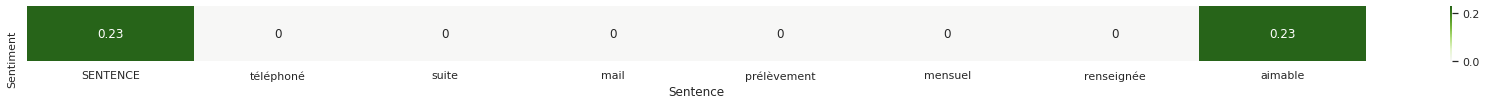

In [ ]:
sid = SentimentIntensityAnalyzer()
sid.polarity_scores(sentence)


visualise_sentiments({
    "Sentence":["SENTENCE"] + sentence.split(),
    "Sentiment":[sid.polarity_scores(sentence)["compound"]] + [sid.polarity_scores(word)["compound"] for word in sentence.split()]
})

## TextBlob

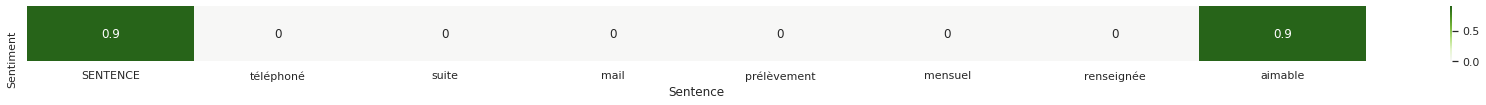

In [ ]:
tb = Blobber(pos_tagger=PatternTagger(), analyzer=PatternAnalyzer())

visualise_sentiments({
    "Sentence":["SENTENCE"] + sentence.split(),
    "Sentiment":[tb(sentence).sentiment[0]] + [tb(word).sentiment[0] for word in sentence.split()]
})

In [ ]:
def vader_sentiment_scores(sentence):
    sentence = " ".join(sentence)
    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)
    
    # decide sentiment as positive, negative and neutral
    #vader has an option for neutral but in our case its just positive/negative so we fix it to be this way.
    if sentiment_dict['compound'] > -0.05 :
        return 1
    else:
        return 0

def text_blob_sentiment_score(text):
  sentence = " ".join(text)
  s= TextBlob(sentence).sentiment.polarity

  if s > -0.05 :
    return 1
  else:
    return 0


In [ ]:
samp = reviews.sample(1000)
samp["sentiment"] = np.where(samp['note']>=4, 1, 0)

In [ ]:
vader_pred = samp.tokens_processed.apply(vader_sentiment_scores)
textBlob_pred = samp.tokens_processed.apply(text_blob_sentiment_score)

In [ ]:
from sklearn.metrics import f1_score, accuracy_score


In [ ]:
print(f'F1 score for vader : {f1_score(vader_pred, samp.sentiment)}')
print(f'F1 score for TextBolb : {f1_score(textBlob_pred, samp.sentiment)}')

F1 score for vader : 0.8817065287653523
F1 score for TextBolb : 0.8599651365485184


### Rating vs sentiment

In [ ]:
## TO DO : Explore your dataset
print(reviews.shape)
reviews.head(3)

(30000, 15)


,Unnamed: 0,page,titre,verbatim,date,note,reponse,date_experience,fournisseur,source,clean_verb,tokens,tokens_lem,tokens_processed,tokens_lem_processed
21127,21127,23,Avis client,Pour l’instant aucun problème,le 09/10/2022 par STEPHAN V.,4,None,suite à une expérience du 30/09/2022,https://www.avis-verifies.com/avis-clients/hap...,avis_verifies,pour l’instant aucun problème,"[[pour, ], [l’, ], [instant, ], [aucun, ], [pr...","[[pour, ], [l’, ], [instant, ], [aucun, ], [pr...","[instant, problème]",[instant]
4727,4727,27,Bonjour de la part d’un ancien démarcheur Eni,Bonjour je parle en ayants était démarcheur po...,13 juin 2020,1,None,Date de l'expérience: 13 juin 2020,https://fr.trustpilot.com/review/eni.fr,trustpilot,bonjour je parle en ayants était démarcheur po...,"[[bonjour, ], [je, ], [parle, ], [en, ], [ayan...","[[bonjour, ], [je, ], [parl, ], [en, ], [ayant...","[bonjour, ayants, démarcheur, eni, semaineon, ...","[bonjour, parl, démarcheur, eni, pend, semaine..."
3402,3402,113,OHM énergie n'a pas attendu le délai de…,OHM énergie n'a pas attendu le délai de rétrac...,10 mars 2021,1,"Bonjour,\nL'annulation aurait pu se faire plus...",Date de l'expérience: 10 mars 2021,https://fr.trustpilot.com/review/ohm-energie.com,trustpilot,ohm énergie n'a pas attendu le délai de rétrac...,"[[ohm, ], [énergie, ], [n', ], [a, ], [pas, ],...","[[ohm, ], [énerg, ], [n', ], [a, ], [pas, ], [...","[ohm, énergie, délai, rétractation, prélever, ...","[ohm, énerg, del, rétract, prélev, somm, argen..."


<AxesSubplot:ylabel='Frequency'>

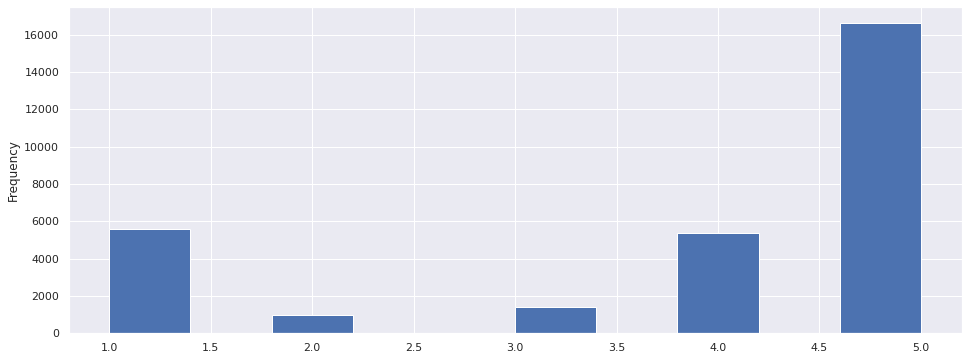

In [ ]:
plt.figure(figsize = (16,6))
reviews.note.plot.hist()

In [ ]:
## TO DO : by using a threshold between 14 an 16, identifiy positif reviews and not positif reviews
reviews['sentiment'] = np.where(reviews['note']>=4, "pos", "not_pos")           

In [ ]:
reviews.head(2)

,Unnamed: 0,page,titre,verbatim,date,note,reponse,date_experience,fournisseur,source,clean_verb,tokens,tokens_lem,tokens_processed,tokens_lem_processed,sentiment
21127,21127,23,Avis client,Pour l’instant aucun problème,le 09/10/2022 par STEPHAN V.,4,None,suite à une expérience du 30/09/2022,https://www.avis-verifies.com/avis-clients/hap...,avis_verifies,pour l’instant aucun problème,"[[pour, ], [l’, ], [instant, ], [aucun, ], [pr...","[[pour, ], [l’, ], [instant, ], [aucun, ], [pr...","[instant, problème]",[instant],pos
4727,4727,27,Bonjour de la part d’un ancien démarcheur Eni,Bonjour je parle en ayants était démarcheur po...,13 juin 2020,1,None,Date de l'expérience: 13 juin 2020,https://fr.trustpilot.com/review/eni.fr,trustpilot,bonjour je parle en ayants était démarcheur po...,"[[bonjour, ], [je, ], [parle, ], [en, ], [ayan...","[[bonjour, ], [je, ], [parl, ], [en, ], [ayant...","[bonjour, ayants, démarcheur, eni, semaineon, ...","[bonjour, parl, démarcheur, eni, pend, semaine...",not_pos


### Preprocessing

In [ ]:
reviews = reviews[reviews['clean_verb']!=""]

In [ ]:
reviews.head(3)

,Unnamed: 0,page,titre,verbatim,date,note,reponse,date_experience,fournisseur,source,clean_verb,tokens,tokens_lem,tokens_processed,tokens_lem_processed,sentiment
21127,21127,23,Avis client,Pour l’instant aucun problème,le 09/10/2022 par STEPHAN V.,4,None,suite à une expérience du 30/09/2022,https://www.avis-verifies.com/avis-clients/hap...,avis_verifies,pour l’instant aucun problème,"[[pour, ], [l’, ], [instant, ], [aucun, ], [pr...","[[pour, ], [l’, ], [instant, ], [aucun, ], [pr...","[instant, problème]",[instant],pos
4727,4727,27,Bonjour de la part d’un ancien démarcheur Eni,Bonjour je parle en ayants était démarcheur po...,13 juin 2020,1,None,Date de l'expérience: 13 juin 2020,https://fr.trustpilot.com/review/eni.fr,trustpilot,bonjour je parle en ayants était démarcheur po...,"[[bonjour, ], [je, ], [parle, ], [en, ], [ayan...","[[bonjour, ], [je, ], [parl, ], [en, ], [ayant...","[bonjour, ayants, démarcheur, eni, semaineon, ...","[bonjour, parl, démarcheur, eni, pend, semaine...",not_pos
3402,3402,113,OHM énergie n'a pas attendu le délai de…,OHM énergie n'a pas attendu le délai de rétrac...,10 mars 2021,1,"Bonjour,\nL'annulation aurait pu se faire plus...",Date de l'expérience: 10 mars 2021,https://fr.trustpilot.com/review/ohm-energie.com,trustpilot,ohm énergie n'a pas attendu le délai de rétrac...,"[[ohm, ], [énergie, ], [n', ], [a, ], [pas, ],...","[[ohm, ], [énerg, ], [n', ], [a, ], [pas, ], [...","[ohm, énergie, délai, rétractation, prélever, ...","[ohm, énerg, del, rétract, prélev, somm, argen...",not_pos


In [ ]:
# TO DO : number of positif / negatif comment 
reviews.sentiment.value_counts()

pos        21958
not_pos     7996
Name: sentiment, dtype: int64

## Vectorization with tfidf

In [ ]:
data = reviews.copy()
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


docs = data.tokens_processed.map(lambda tokens: " ".join(tokens))

min_df = .05
max_df = 0.9

vectorizer = TfidfVectorizer(min_df=min_df,
                             max_df=max_df,
                             analyzer="word",
                             ngram_range=(1,2))

matrix = vectorizer.fit_transform(docs)
print(matrix.shape)
# os.mkdir("output/")
pickle.dump(vectorizer, open(os.path.join("./output", f"vectorizer_avis.pkl"), "wb"))

X = matrix
y = np.where(data["sentiment"] == "pos", 1, 0)

(29954, 16)


**what is the importance of the parmeters min_df and max_df** ?

It's the frequency of words that appear which we want to ignore. So any words over the max_df and below the min_df threshold will be neglected. This is important as words that appear in every single sentence is not important and the same for words that appear too little.

In [ ]:
### Se the tfidf matrix
column = np.array(vectorizer.get_feature_names_out())
df_tfidf = pd.DataFrame(matrix.todense(), columns = column)
df_tfidf.head()

,client,contrat,facture,faire,fournisseur,mois,rapide,service,service client,souscription,technicien,total,téléphone,écoute,électricité,énergie
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## Train a Logistic Regression Classifier

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,f1_score, accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
classifier = LogisticRegression(class_weight = 'balanced', random_state=2023 )

# Train test split with classes stratify
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=2023)

model = classifier.fit(X_train, y_train) # fit your model
yhat = model.predict(X_test)  # predict in test data

print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.58      0.65      0.61      2399
           1       0.87      0.83      0.85      6588

    accuracy                           0.78      8987
   macro avg       0.72      0.74      0.73      8987
weighted avg       0.79      0.78      0.78      8987



## Explain the  review’s sentiment 

We can use [SHAP](https://shap.readthedocs.io/en/latest/index.html) to explain our model. 

In the following graphique **Feature Value** refers to  the frequence of the word in the reviews. So in the plots below the positive features are actually helping raise the chance of a positive review, while the negative features are lowering the chance. It is interesting to see how what is not present in the text  is often just as important as what is in the text. Remember the values of the features are TF-IDF values.



The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)


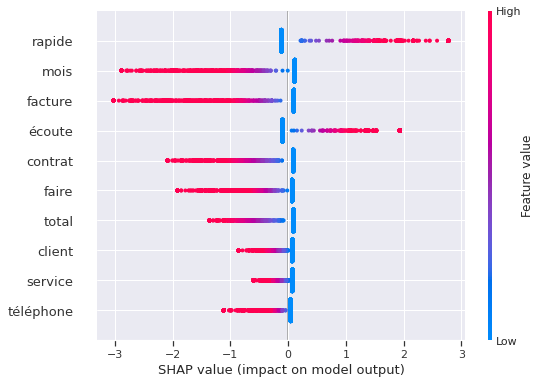

In [ ]:
import shap

explainer = shap.LinearExplainer(
    model, X_train, feature_dependence="independent")
shap_values = explainer.shap_values(X_test)
# we need to pass a dense version for the plotting functions
X_test_array = X_test.toarray()

shap.summary_plot(shap_values, X_test_array,
            feature_names=vectorizer.get_feature_names_out(), max_display=10)

Word like **rapide**, **professionnel**, **efficace**, **facture**, **écoute** ... are associated to negative comments.

## Prediction

define first a pipline to pre-process a text input and apply the vectoriser 

In [ ]:
def join_tok(tokens):
    return [' '.join(tokens)]
    
Pipeline = {'tokenize': process.tokenize_stemme,
            'clean_token': process.clean_tokens,
            'join' : join_tok,
            'tfidf' : vectorizer.transform,
           
          }

def DetectSentiment(text, model):
  for func in Pipeline:
      text = Pipeline[func](text)
      
  return model.predict_proba(text)[0][1] # score of the positive classe

In [ ]:
text = "Je suis très déçu par les services offerts par Total Energie. J'ai trouvé leur service clientèle\
        désorganisé et leur manque de communication a été très décevant. Je ne recommanderais pas Total Energie à mes amis."

DetectSentiment(text, model)

0.7003010211679256

In [ ]:
# TO DO : 


# 0 - Using documentations, what is the diffrence between Vader and textBlob ? Do they calculate the scores in the same way ?
# 1 -  Compare the performence between vader and the Logistique regression classifier.

## HINT : 
#       - Separate negative reviews and positif reviews
#       - Compare Logistic regression's scores  and vader'r scores in each groupe

# 2 -  Use a Decision Tree classier instead of Logistique regression. Do you have better results ?
# 3 -  Use an embedding approach instead of tfifd. Do you have better results ?
